# Исследование рынка компьтерных игр. Определение закономерностей, определяющих успех игры


<div style="border:solid green 3px; padding: 20px">
<b>Закачик - интернет магазин "Стримчик"</b>


<b>Описание исследования:</b>

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
    
<b>Задача </b> - нужно выявить определяющие успешность игры закономерности, позволяющие сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Предоставленны данные до 2016 года. Сейчас декабрь 2016 г., и планируется рекламная кампания кампанию на 2017-й. 
Нужно отработать принцип работы с данными. Неважно, прогнозируются ли продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

<b>аббревиатура ESRB (Entertainment Software Rating Board)</b> — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например:
- «Для взрослых», 
- «Для детей младшего возраста», 
- «Для подростков»
- и тд.


_Данные за 2016 год могут быть неполными._

## Импорт библиотек и подготовка

In [1]:
# импортирую все библиотеки, которые могут понадобиться в ходе исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
from math import factorial
import statsmodels.api as sm 

In [2]:
# отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
# хочу видеть все таблицы полностью, если они будут слишком объемными
pd.set_option('display.max_columns', 100)

## Знакомство с данными

In [4]:
# таблица с необходимой информацией
# использую try / except для оптимизации перехода с работы на платформе на локальный режим
try:
    games_df = pd.read_csv('/datasets/games.csv')
except:
    games_df = pd.read_csv('../Downloads/games.csv')

display(games_df.head(10))
games_df.columns

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

<b>Описание данных</b>
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Обработка названий столбцов

Для оптимизаци дальнейшей работы внесу следующие изменения в названия столбцов датафрейма:
- сменю регистр на нижний
- Year_of_Release для сокращения названия укажу столбец как releases_year

In [5]:
games_df.columns = ['name', 'platform', 'releases_year', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           16713 non-null  object 
 1   platform       16715 non-null  object 
 2   releases_year  16446 non-null  float64
 3   genre          16713 non-null  object 
 4   na_sales       16715 non-null  float64
 5   eu_sales       16715 non-null  float64
 6   jp_sales       16715 non-null  float64
 7   other_sales    16715 non-null  float64
 8   critic_score   8137 non-null   float64
 9   user_score     10014 non-null  object 
 10  rating         9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Смена типов данных

На основании информации, представленной выше, необходимо сменить тип данных у следующих столбцов:
- releases_year - год выпуска является целым числом, приведу к целочисленному формату Int64
- user_score - рейтинг должен иметь числовой формат, при этом может быть указан с дробной частью. Необходимо определить причину типа данных object

In [6]:
games_df['releases_year'] = games_df['releases_year'].astype('Int64')

In [7]:
games_df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо пропущенных значений, коих в столбце немногим больше 6 тысяч, имеет значение 'tbd'(to be determined). Проверю сколько таких значений.

In [8]:
len(games_df.query('user_score == "tbd"'))

2424

Фактически, это отсутсвие информации, поэтому переведу 'tbd' в обычные nan.

In [9]:
games_df.loc[games_df['user_score'] =='tbd','user_score'] = np.nan
games_df['user_score'] = games_df['user_score'].astype('float')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           16713 non-null  object 
 1   platform       16715 non-null  object 
 2   releases_year  16446 non-null  Int64  
 3   genre          16713 non-null  object 
 4   na_sales       16715 non-null  float64
 5   eu_sales       16715 non-null  float64
 6   jp_sales       16715 non-null  float64
 7   other_sales    16715 non-null  float64
 8   critic_score   8137 non-null   float64
 9   user_score     7590 non-null   float64
 10  rating         9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


Теперь со столбцом user_score все в порядке, и пропущенных значений в нем стало больше на 2424 - ровно столько  'tbd'-значений было. Замена прошла успешно.

На данный момент тип столбцов датафрейма меня устраивает.

### Работа с пропусками

In [10]:
games_df.isna().sum()

name                2
platform            0
releases_year     269
genre               2
na_sales            0
eu_sales            0
jp_sales            0
other_sales         0
critic_score     8578
user_score       9125
rating           6766
dtype: int64

В первую очередь, я вижу, что есть 2 пропуска в столбце 'name', проверю, что это за строки.

In [11]:
games_df[games_df['name'].isnull()]

,name,platform,releases_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Проводить анализ игры без названия - попытка перелить из пустого в порожнее. Данные строки удаляю.

In [12]:
games_df = games_df.dropna(subset=['name'])

Помимо столбца с указанием названия игры, пропуски имеются в столбцах:
- releases_year 
- critic_score 
- user_score 
- rating 

#### releases_year

Посмотрю на эти данные поближе.

In [13]:
games_df[games_df['releases_year'].isnull()].head(10)

,name,platform,releases_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.00,0.07,73.0,NaN,E
678,LEGO Indiana Jones: The Original Adventures,Wii,<NA>,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,<NA>,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,<NA>,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


У меня было предположение, что данных релиза нет, так как это старые игры, но я вижу, что многие из них вышли на современных платформах. В идеале, эти данные можно было бы заполнить вручную, прогуглив информацию о выходе игры на той или иной платформе.

Вариант заполнения медианным или средним значением года выхода, в зависимости от типа платформы, мне не кажется объективным, потому что, например PS3 вышла через 6 лет после выпуска PS2, и все эти 6 лет прошли сотни релизов игр для этой плтаформы (долгое время она считалась лидером индустрии). Заполнение может привести к ошибке данных. 

Учитывая тот факт, что год релиза является важным фактором (именно по нему, в том числе, будет происходить срез данных), а также что процент пропусков в этой колонке изначально составлял лишь 1,6%, то я удалю эти пропуски. 


In [14]:
games_df = games_df.dropna(subset=['releases_year'])

#### rating

Познакомлюсь с колонкой поближе. 

In [15]:
games_df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Пропуски в данном случае могут означь, что:
- рейтинг мог быть не присвоен
- рейтинг не внесли в базу данных
- информация о рейтинге отсутсвует

Все это означает только одно - нет информации, поэтому пропуски заполню "no_info", это не изменит тип данных, и позволит продолжить работу с ним.

In [16]:
games_df['rating'] = games_df['rating'].fillna('no_info')

In [17]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           16444 non-null  object 
 1   platform       16444 non-null  object 
 2   releases_year  16444 non-null  Int64  
 3   genre          16444 non-null  object 
 4   na_sales       16444 non-null  float64
 5   eu_sales       16444 non-null  float64
 6   jp_sales       16444 non-null  float64
 7   other_sales    16444 non-null  float64
 8   critic_score   7983 non-null   float64
 9   user_score     7463 non-null   float64
 10  rating         16444 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


#### critic_score & user_score

В колонках содержатся только числовые значения, что следует из типа данных столбца. Однако, несколько прискорбно, что в колонках содержится катастрофическое число пропусков. Причины пропусков я вижу следующие:
- игры, выпущенные до популярицации оценок (об этом так же может говорить примерно одинаковое число пропусков)
- в базу не внесены данные об оценках


Посмотрю на гистограммы распределения данных.

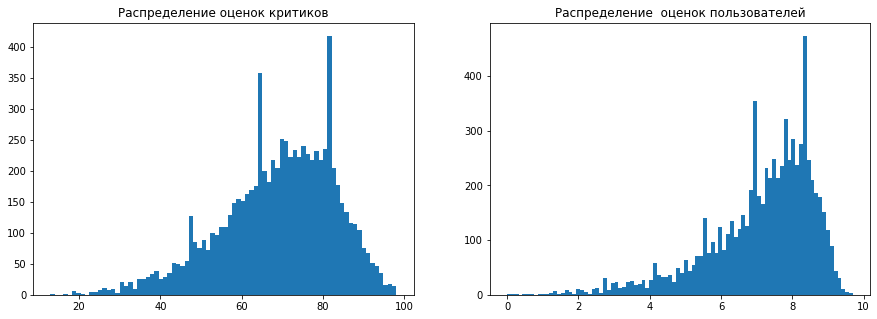

In [18]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax1[0].hist(games_df['critic_score'], bins=80);
ax1[0].set_title('Распределение оценок критиков')

ax1[1].hist(games_df['user_score'], bins=90);
ax1[1].set_title('Распределение  оценок пользователей');

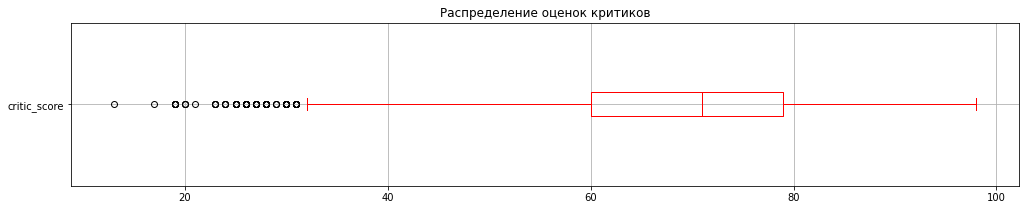

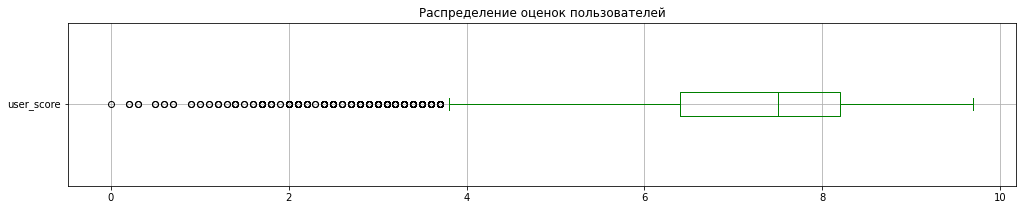

In [19]:
# распределение оценок критиков
fig, ax = plt.subplots(figsize = (17,3))
ax = games_df[['critic_score']].boxplot(vert = False, color='red', ax =ax)
ax.set_title('Распределение оценок критиков');
plt.show()

# распределение оценок пользователей
fig, ax = plt.subplots(figsize = (17,3))
ax = games_df[['user_score']].boxplot(vert = False, color='green', ax =ax);
ax.set_title('Распределение оценок пользователей');


По построенным выше гистограммам и диаграммам размаха оцевиден перекос данных влево (достаточное число слишком низких оценок), что не позволяет заполнить пропуски средним или медианным значением, это может сильно искозить общую картину.

Пока я ничего не буду делать с этим столбцом и при необходимости воспользуюсь условиями мягкой фильтрации. Можно было бы уже сейчас заполнить пропуски так называемыми "заглушками" (например значением 999), но пока я воздержусь от принятия этого решения.

### Суммарные продажи в регионах

Сумму продаж посчитаю одной строкой. Результат вычесления внесу в столбец total_sales.

In [20]:
games_df['total_sales'] = games_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
games_df.head()

,name,platform,releases_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no_info,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no_info,31.38


Все в порядке, определение суммарных продаж прошло успешно.

## Исследовательский анализ

### Выпуск игр в разные годы

In [21]:
games_df.groupby('releases_year')['name'].count()

releases_year
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Не для кого не секрет, что индустрия видео-игр шагает семимильными шагами. Еще 10 лет назад сложно было представить, то многообразие игр, что ест сейчас. Это видно и на отсориторованных данных - согласно данным, ввз]тым для исследования за 2016 год было выпущено почти столько же игр, что и с 1980 по 2000.

Более наглядно картину отобразит график.

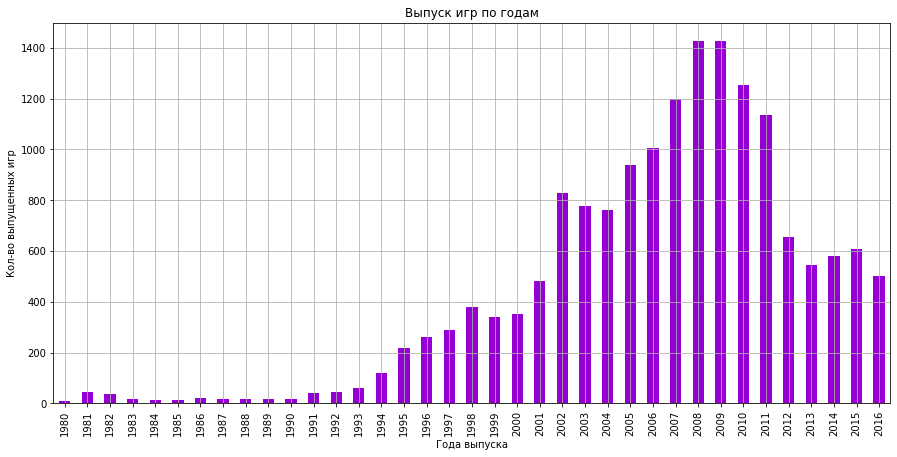

In [22]:
(games_df.groupby('releases_year')['name'].count().
plot(kind='bar', x='releases_year',color='darkviolet', title='Выпуск игр по годам', figsize=(15, 7), grid=True)
)

plt.ylabel('Кол-во выпущенных игр')
plt.xlabel('Года выпуска')

plt.show()

На графике картина становится более понятной.
- в сравнении с нынешним рынком видео-игр до 1994 года игры почти не выпускались (кстати, в этом году вышла первая Sony Play Station, ставшей одной из самых популярных игровых консолей и покорившей столько сердец).
- заметен рост в числе выпущенных в год игр с 1994 года по 1998.
- в 1999 и 2000 гг. небольшой спад в сравнении с 1998.
- значительный спад индустрии после 2011 года. Возможно это последствия кризиса 2008 года. 

Также такой спад релизов может объяснять погоня разработчиков игр за качеством, а не за количеством, ведь сегодняшнего пользователя сложно чем-то удивить, в связи с чем релизы игр откладываются из-за проработок мельчайших деталей. Например если между выходом GTA и GTA-2 прошел всего год, то фанатам серии, прошедшим GTA-4 в 2008 году пришлось ждать релиз следующей серии целых 5 лет.

Все это говорит о том, что рынок компьютерных игр меняется скоротечно и, скорее всего, чтобы опираться на его тренды для исследования <b>достаточно будет взять данные за последние 7 лет - с 2010 по 2016<b/>.

    

### Объем продаж по платформам

In [23]:
games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Что и следовало ожидать - самой популярной платформой видео-игр в период с 1980 года была игровая консоль PS2.

Необходимо отобрать платформы, имеющие наибольшие продажи. Я отберу 18 платфом - от PS2 до XOne. Такой выбор я объясню тем, что:
- у этого перечня приставок продажи "перевалили" за 100 млн.
- мне кажется странным, что XOne не будет в топе, так как на этапе своего выхода она была очень популярна и конкурировала с PS4 (хоть и на нее выходило меньше игр).

In [24]:
# создам список 18 лидирующих по продажам платформах
platforms_top_list = games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:18].index
platforms_top_list

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS',
       'PC', 'GB', 'XB', 'NES', 'N64', 'SNES', 'GC', 'XOne'],
      dtype='object', name='platform')

In [25]:
platforms_top = games_df.query('platform in @platforms_top_list').reset_index()
platforms_top

,index,name,platform,releases_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no_info,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no_info,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15464,16708,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,0.00,0.00,0.00,NaN,NaN,no_info,0.01
15465,16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,no_info,0.00
15466,16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,no_info,0.01
15467,16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,no_info,0.01


Теперь построю графики по которым можно будет увидеть, так сказать, жизненный цикл платформы.

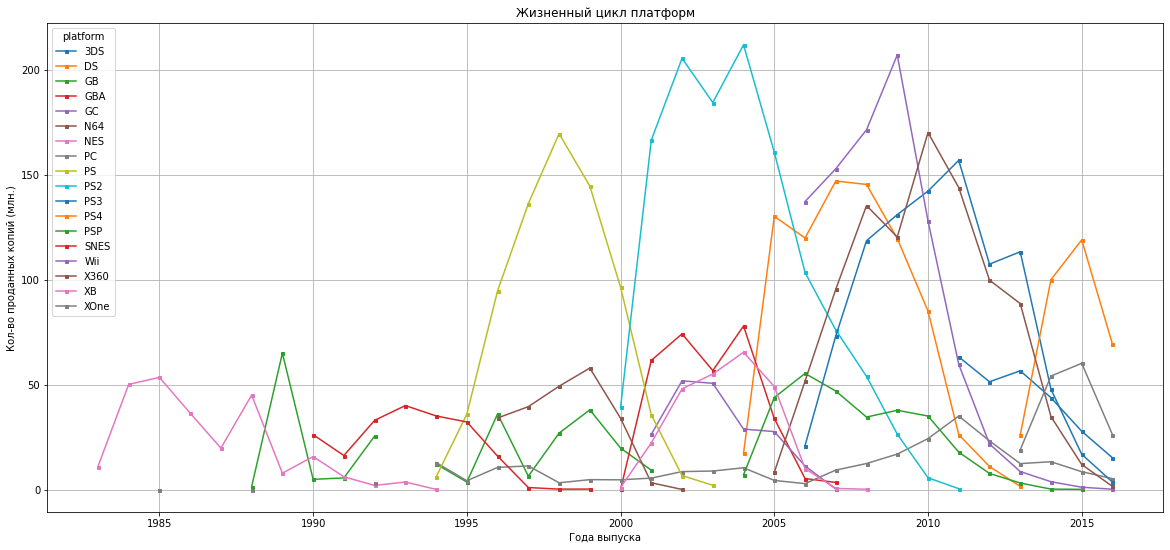

In [26]:
platforms_top.pivot_table(index='releases_year', columns='platform', values='total_sales', 
                          aggfunc='sum').plot(kind='line', figsize=(20, 9), grid=True, marker = 's',
        markersize = 3, legend=True, title='Жизненный цикл платформ');

plt.ylabel('Кол-во проданных копий (млн.)')
plt.xlabel('Года выпуска')

plt.show()

По данному графику можно увидеть, что самые популярные платформы могут жить до 20 лет, и, при чем, выходить на пик к своему 10му дню рождения. Например ранее упомянутая мною PS, пожалуй, это одна из самых долгоиграющих платформ.

Самые популярные по пр

Однако, ранее я писала о темпах развития игровой индустрии, и на графике видно, что среди популярных платформ есть те, что были популярны в прошлом веке. Ограничу выборку 2000 годом.

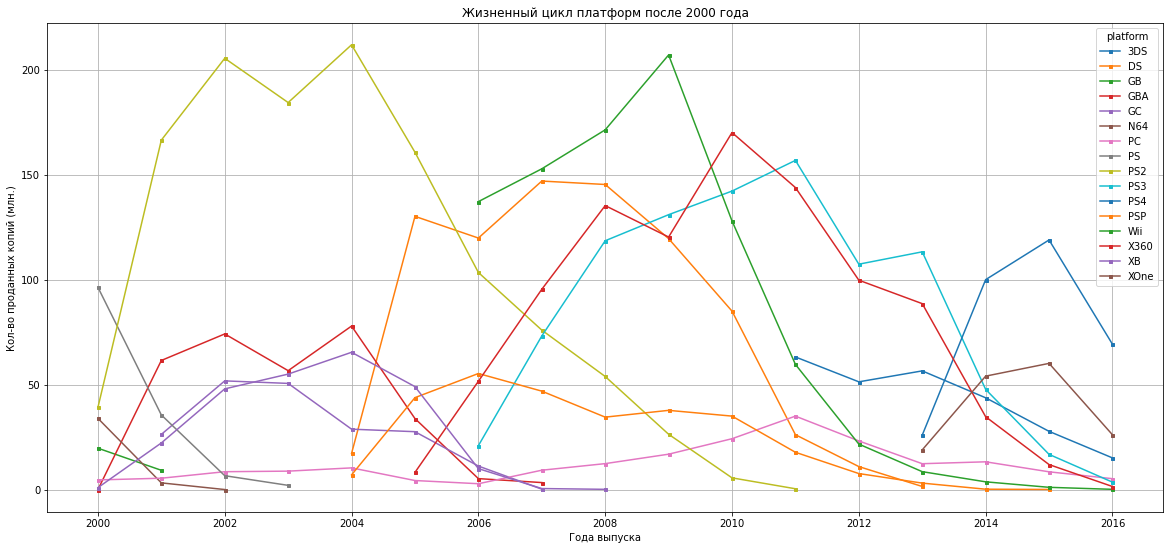

In [27]:
platforms_top.query('releases_year >= 2000').pivot_table(index='releases_year', columns='platform', values='total_sales', 
                          aggfunc='sum').plot(kind='line', figsize=(20, 9), grid=True, marker = 's',
        markersize = 3, legend=True, title='Жизненный цикл платформ после 2000 года');

plt.ylabel('Кол-во проданных копий (млн.)')
plt.xlabel('Года выпуска')

plt.show()

По графику можно отметить ряд моментов:
1. Безусловный лидер по продолжительности своей жизни - PS, продажи игр на данную платформу продолжают вплоть до 2016 года.
2. В среднем продолжительность жизни игровых платформ близится к 10-11 гг. 
3. Среди вышедших в одно и тоже время приставок PS4 и XboxOne с огромным отрывом лидирует первая. Но это может быть связано, что на PS4 многие популярные игры выходили раньше.
4. На уровне пика, сравнимого с популярностью, PS2 в 2009 году была Game Boy.
5. Более продолжительный цикл жизни был у приставки Game Boy Advance, хоть и игр было продано на пике примерно на 30 млн. меньше, чем у Game Boy.
6. Очевидный вывод, что самой популярной игровой платформой являются консоли компании Sony.
7. На пик своей популярности в среднем приставка выходит примерно на 2-3 год после выпуска.
8. Очевидна тендеция сокращения времени выпуска новых платформ, новые консоли со временем стали выходить значительно чаще.

### Формирование актуального периода.

Как было отмечено ранее, игровые консоли выходят чаще. В среднем, игровые консоли обновляются кажные 5-6 лет. Ранее я определила, актуальный период за 7 лет - с 2010 по 2016. Описараясь на частоту обновления игровых платформ, данный срок можно сократить до 6 лет - <b>актуальный период с 2011 по 2016 включительно.<b/>
    
Сформирую датафрейм для анализа, опираясь на этот период.    

In [28]:
actually_games = games_df.query('releases_year >= 2011').reset_index()
actually_games

,index,name,platform,releases_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
3,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_info,14.63
4,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no_info,14.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4017,16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no_info,0.01
4018,16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no_info,0.01
4019,16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,no_info,0.01
4020,16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no_info,0.01


### Выпуск игр в актуальный период

In [29]:
actually_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS3     445.57
X360    380.38
PS4     314.14
3DS     257.81
XOne    159.32
PC       97.68
Wii      95.02
WiiU     82.19
PSV      53.81
DS       38.73
PSP      29.01
PS2       0.45
Name: total_sales, dtype: float64

In [30]:
# для наглядности сореру данные в датафрейм
top_platform = pd.DataFrame({'old_top10': ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'],
                            'new_top10': ['PS3', 'X360', 'PS4', '3DS', 'XOne', 'PC', 'Wii', 'WiiU', 'PSV', 'DS']})

top_platform 

,old_top10,new_top10
0,PS2,PS3
1,X360,X360
2,PS3,PS4
3,Wii,3DS
4,DS,XOne
5,PS,PC
6,PS4,Wii
7,GBA,WiiU
8,PSP,PSV
9,3DS,DS


По данным можно сделать следующие выводы:
1. По актуальному периоду из десятки лучших пропала платформа PS2 зато вошла XOne
2. PS3 довольно популярная платформа в любой период, в актуальном она занимает первую строчку пообъему продаж.
3. учитывая, что 3DS значится в десятке наиболее популярных за весь период, а в актуальном занимает и вовсе 4 место, можно не опасаясь сделать вывод, что данную платформу можно назвать лидером индустрии.

В целом, сравнив данные за весь период, и актуальный период, можно составить следующий перечень перспективных платформ:
- 'PS3'
- 'X360'
- 'PS4'
- '3DS' 
- 'XOne'

Чтобы утвердиться в своем выборе или его опровергруть, построю график по актуальному периоду.

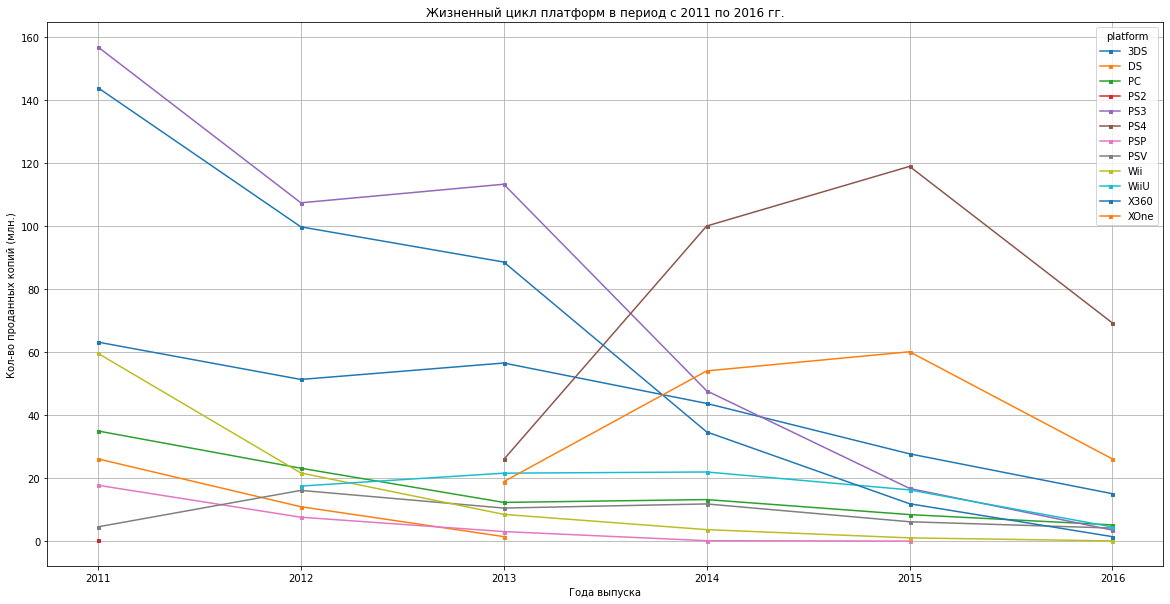

In [31]:
actually_games.pivot_table(index='releases_year', columns='platform', values='total_sales', 
                          aggfunc='sum').plot(kind='line', figsize=(20, 10), grid=True, marker = 's',
        markersize = 3, legend=True, title='Жизненный цикл платформ в период с 2011 по 2016 гг.');

plt.ylabel('Кол-во проданных копий (млн.)')
plt.xlabel('Года выпуска')

plt.show()  

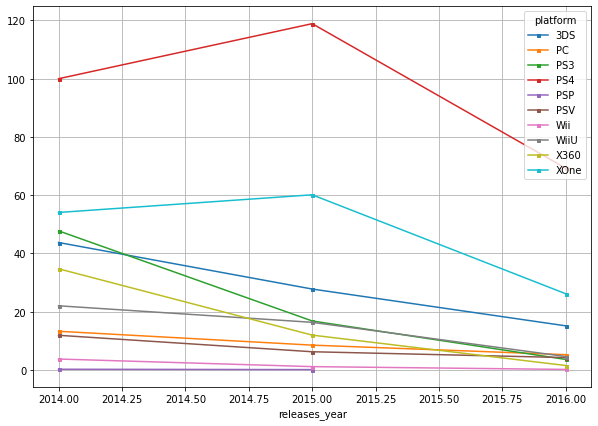

In [32]:
# посмотрю последние 2 года поближе
actually_games.query('releases_year >= 2014').pivot_table(index='releases_year', columns='platform', values='total_sales', 
                          aggfunc='sum').plot(kind='line', figsize=(10, 7), grid=True, marker = 's',
        markersize = 3, legend=True,);

Уже по графику видно, что ряд платформ вышла на этап своего заката, а именно:
- Wii
- PSP
- 3DS
- PSV
- PS

Все еще довольно популярны платформы:
- PS4
- XOne
- 3DS
- PS3
- X360

Эти выводы соответсвует тому, чтобы были сделаны ранее.
Поэтому <b>именно эти платформы приму за перспективные<b/>

### Объем продаж в актуальный период

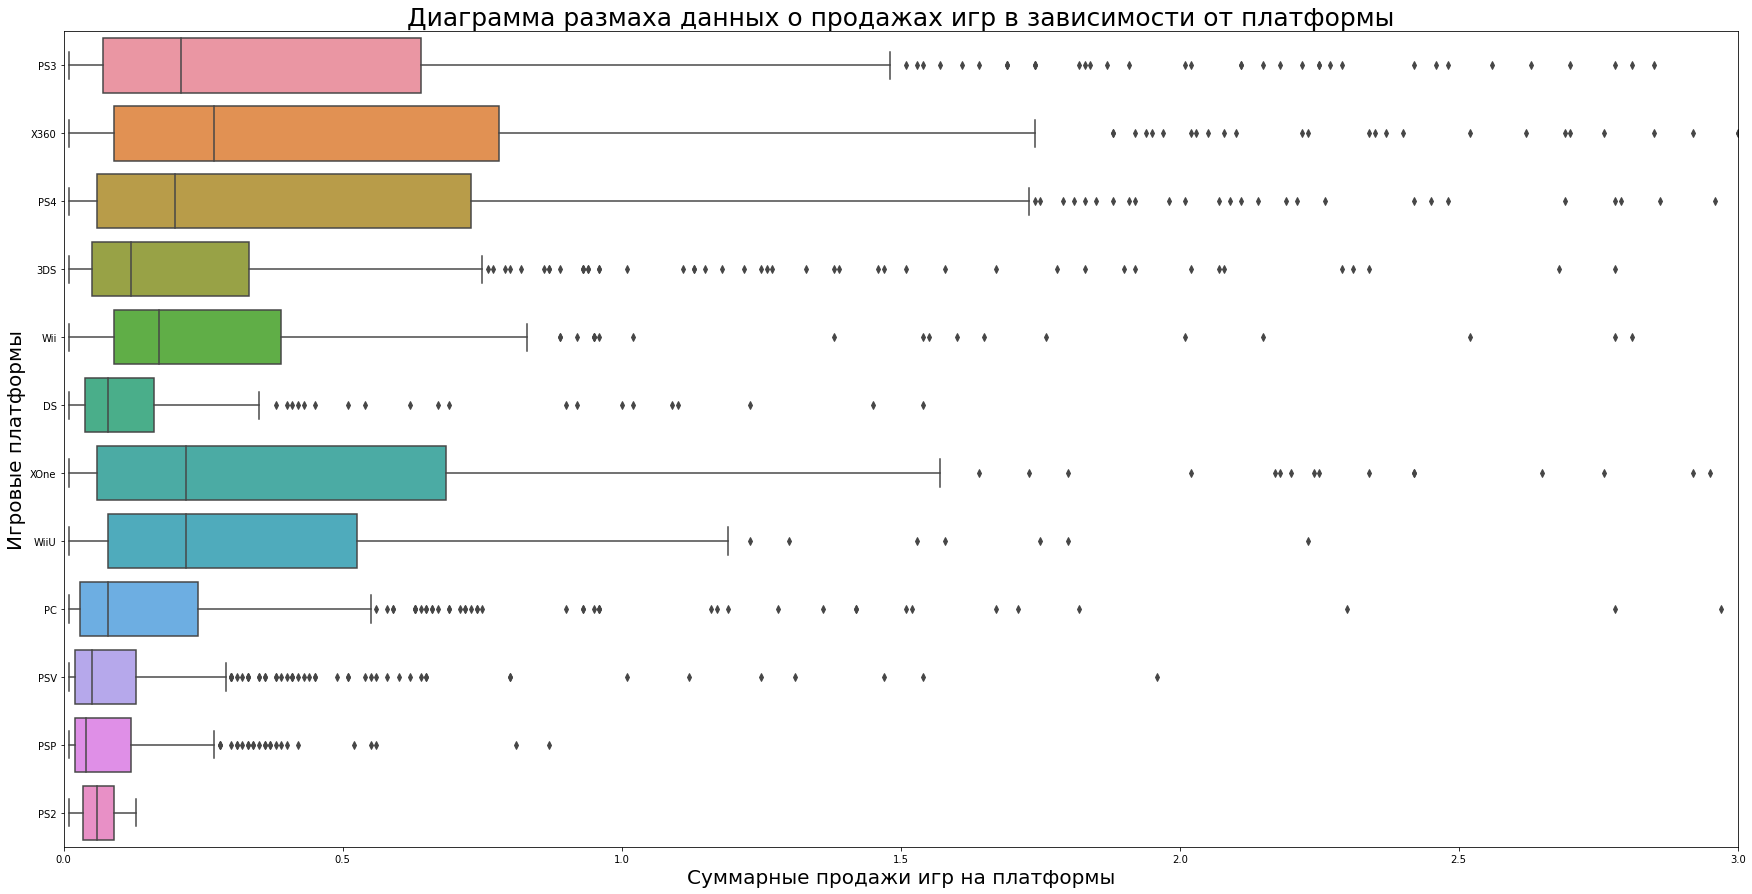

In [33]:
# построение боксплотов глобальных продаж
plt.figure(figsize = (30, 15))
sns.boxplot(data=actually_games, x='total_sales', y='platform')

plt.title('Диаграмма размаха данных о продажах игр в зависимости от платформы', fontsize=25)
plt.xlabel('Суммарные продажи игр на платформы', fontsize=20)
plt.ylabel('Игровые платформы', fontsize=20)
plt.xlim(0, 3) # обрезала границы осих х так как изначально было ничего не понять

plt.show()

Мне хорошо запомнился пример для интерпретации boxplot - представь, что смотришь на гистогграмму сверху вниз - это и есть ящик с усами. Именно поэтому можно заключить что, чем больше межквартальный размах, тем более популярна, с точки зрения продаж, игровая консоль.
По данному графику можно сделать вывод, что несомненными лидерами индустрии с точки зрения продаж являются:
- X360
- PS4
- XOne
- PS3

Все из этих платфом имеют перекос в большую сторону, возможно это связано с отдельными играми, чьи продажи значительно выше, по отношению к другим (например та же многими иожидаемая GT5). В целом по всем платформам игры продаются в пределах 1,8 млн. копий.


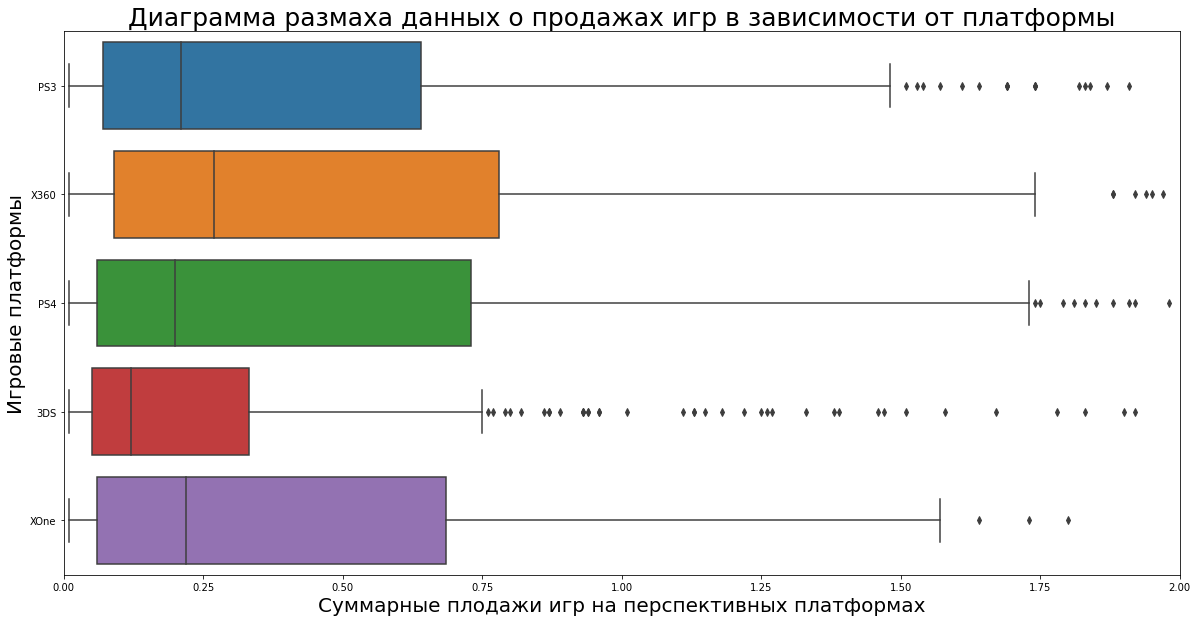

In [34]:
# построение боксплотов глобальных продаж для перспективных платформ
super_platform = ['PS3', 'X360', 'PS4', '3DS', 'XOne']

plt.figure(figsize = (20, 10))
sns.boxplot(data=actually_games.query('platform in @super_platform'), x='total_sales', y='platform')

plt.title('Диаграмма размаха данных о продажах игр в зависимости от платформы', fontsize=25)
plt.xlabel('Суммарные плодажи игр на перспективных платформах', fontsize=20)
plt.ylabel('Игровые платформы', fontsize=20)
plt.xlim(0, 2) # обрезала границы осих х так как изначально было ничего не понять

plt.show()

В целом распределение всех платформ схоже, и общей картины выбивается только 3DS. В отличии от остальных консолей, это портативная приставка. 


### Влияние на продажи оценок критиков и пользователей

В рамках исследования по определению закономерностей логично проверить, влияют ли оценки критиков и зрителей на продажи игр на различные платформы. 

Исследовать я буду три приставки:
- PS4 и XOne - они вышли примерно в одно время и считались конкурентами.
- Nintendo 3DS - потому что это отличная от остальных типов платформ.

#### Влияние на продажи оценок PS4

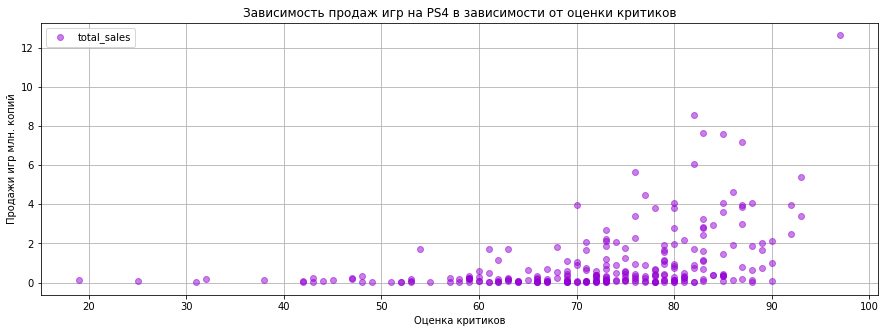

In [35]:
# зависимость от оценок критиков

(actually_games.query('platform == "PS4"')
 .sort_values(by='critic_score', ascending=True)
 .plot(x='critic_score', y='total_sales', style='o', figsize=(15, 5), color='darkviolet',
       grid=True, alpha=0.5, title='Зависимость продаж игр на PS4 в зависимости от оценки критиков')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка критиков')
plt.show()

In [36]:
# корреляция продаж от оценок критиков
actually_games.query('platform == "PS4"')['critic_score'].corr(actually_games.query('platform == "PS4"')['total_sales'])

0.40656790206178095

Построенный график и значение корреляции говорят о том, что зависимость объемов продаж все же имеется. 
Мне инетересно посмотреть на выбивающееся значение - игру, которую критики оценили почти в 100.

In [37]:
actually_games.query('platform == "PS4" and critic_score > 95').T

,9
index,42
name,Grand Theft Auto V
platform,PS4
releases_year,2014
genre,Action
na_sales,3.96
eu_sales,6.31
jp_sales,0.38
other_sales,1.97
critic_score,97.0


То о чем я говорила, Grand Theft Auto V - это классика:)

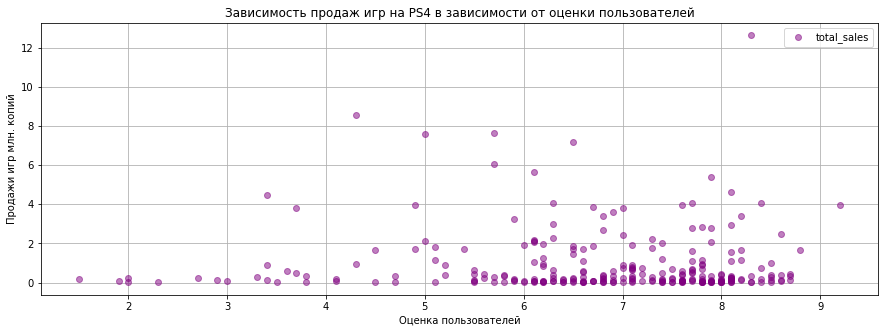

In [38]:
# зависимость от оценок пользователей
(actually_games.query('platform == "PS4"')
 .sort_values(by='user_score', ascending=True)
 .plot(x='user_score', y='total_sales', style='o', figsize=(15, 5), color='purple',
       grid=True, alpha=0.5, title='Зависимость продаж игр на PS4 в зависимости от оценки пользователей')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка пользователей')
plt.show()

In [39]:
# корреляция продаж от оценок пользователей
actually_games.query('platform == "PS4"')['user_score'].corr(actually_games.query('platform == "PS4"')['total_sales'])

-0.031957110204556376

Можно сказать, что зависимости объема продаж игр от оценки пользователей нет. 
Здесь мне инетресно посмотерть на выброс где оценка пользователей выше 9. 

In [40]:
actually_games.query('platform == "PS4" and user_score > 9').T

,77
index,303
name,The Witcher 3: Wild Hunt
platform,PS4
releases_year,2015
genre,Role-Playing
na_sales,1.02
eu_sales,2.13
jp_sales,0.23
other_sales,0.59
critic_score,92.0


Не могу не согласиться, Ведьмак - это шедевр.

#### Влияние на продажи оценок XOne

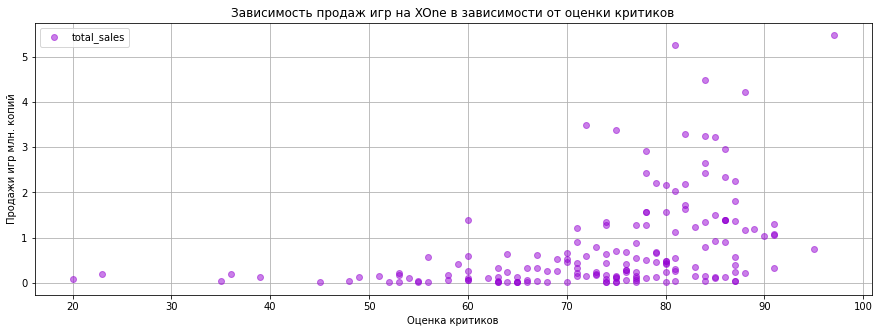

In [41]:
# зависимость от оценок критиков
(actually_games.query('platform == "XOne"')
 .sort_values(by='critic_score', ascending=True)
 .plot(x='critic_score', y='total_sales', style='o', figsize=(15, 5), color='darkviolet',
       grid=True, alpha=0.5, title='Зависимость продаж игр на XOne в зависимости от оценки критиков')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка критиков')
plt.show()

In [42]:
# корреляция продаж от оценок критиков
actually_games.query('platform == "XOne"')['critic_score'].corr(actually_games.query('platform == "XOne"')['total_sales'])

0.4169983280084017

Здесь результаты схожи с тем, что я определила по платформе PS4 - можно сказать, что зависимость оценки критиков на объем продаж есть. 

Как и раньше посмотрю какие игры критики удостоили столь высокой оценки.

In [43]:
actually_games.query('platform == "XOne" and critic_score > 94').T

,44,600
index,165,2720
name,Grand Theft Auto V,Metal Gear Solid V: The Phantom Pain
platform,XOne,XOne
releases_year,2014,2015
genre,Action,Action
na_sales,2.81,0.41
eu_sales,2.19,0.26
jp_sales,0.0,0.01
other_sales,0.47,0.07
critic_score,97.0,95.0


Grand Theft Auto V и снова и опять. Интересно будет посмотреть, какой лидер по оценке пользователей.

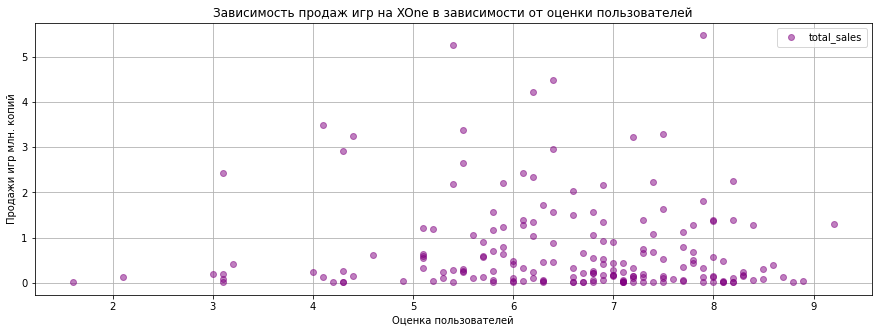

In [44]:
# зависимость от оценок пользователей
(actually_games.query('platform == "XOne"')
 .sort_values(by='user_score', ascending=True)
 .plot(x='user_score', y='total_sales', style='o', figsize=(15, 5), color='purple',
       grid=True, alpha=0.5, title='Зависимость продаж игр на XOne в зависимости от оценки пользователей')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка пользователей')
plt.show()

In [45]:
# корреляция продаж от оценок пользователей
actually_games.query('platform == "XOne"')['user_score'].corr(actually_games.query('platform == "XOne"')['total_sales'])

-0.06892505328279414

Оценка пользователей не влияет на объем продаж. Посмотрю на топ-игру пользователей XOne.

In [46]:
actually_games.query('platform == "XOne" and user_score > 9').T

,339
index,1499
name,The Witcher 3: Wild Hunt
platform,XOne
releases_year,2015
genre,Role-Playing
na_sales,0.69
eu_sales,0.5
jp_sales,0.0
other_sales,0.11
critic_score,91.0


#### Влияние на продажи оценок 3DS

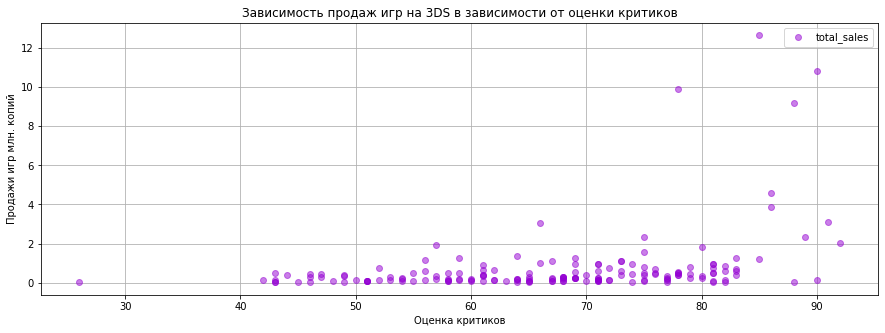

In [47]:
# зависимость от оценок критиков
(actually_games.query('platform == "3DS"')
 .sort_values(by='critic_score', ascending=True)
 .plot(x='critic_score', y='total_sales', style='o', figsize=(15, 5), color='darkviolet',
       grid=True, alpha=0.5, title='Зависимость продаж игр на 3DS в зависимости от оценки критиков')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка критиков')
plt.show()

In [48]:
# корреляция продаж от оценок критиков
actually_games.query('platform == "3DS"')['critic_score'].corr(actually_games.query('platform == "3DS"')['total_sales'])

0.3487397305984834

На платформе 3DS имеет довольно слабое влияние оценки критиков на объем продаж. Скачки наблюдаются на уровне оценки 85 и выше.

In [49]:
actually_games.query('platform == "3DS" and critic_score > 90').T

,112,201
index,448,848
name,The Legend of Zelda: A Link Between Worlds,Fire Emblem: Awakening
platform,3DS,3DS
releases_year,2013,2012
genre,Action,Role-Playing
na_sales,1.4,0.9
eu_sales,1.01,0.45
jp_sales,0.46,0.54
other_sales,0.23,0.13
critic_score,91.0,92.0


Бросается в глаза, что 2 особо популярные игры на Nintendo 3DS по мнению критиков имеют очень высокие оценки пользователей.

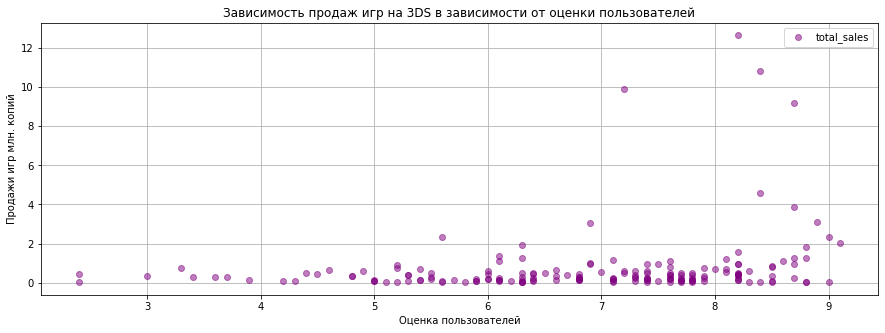

In [50]:
# зависимость от оценок пользователей
(actually_games.query('platform == "3DS"')
 .sort_values(by='user_score', ascending=True)
 .plot(x='user_score', y='total_sales', style='o', figsize=(15, 5), color='purple',
       grid=True, alpha=0.5, title='Зависимость продаж игр на 3DS в зависимости от оценки пользователей')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка пользователей')
plt.show()

In [51]:
# корреляция продаж от оценок пользователей
actually_games.query('platform == "3DS"')['user_score'].corr(actually_games.query('platform == "3DS"')['total_sales'])

0.22207843643390882

Здесь наблюдается отличие от игровых консолей, исследуемых ранее - зависимость продаж от оценки пользователей какая-никакая, но проглядывается.

#### Вывод


<div style="border:solid black 1px; padding: 10px">
На игровы приставках PS4 b XboxOne зафиксирована зависимость объема продаж игр от оценки критиков. Оценка пользователей на объемы продаж фактически не влияет.

Для портативной консоли Nintendo 3DS влияние оценок критиков и пользователей на объем продаж схоже невысокое.

#### Продажи игр на других платформах

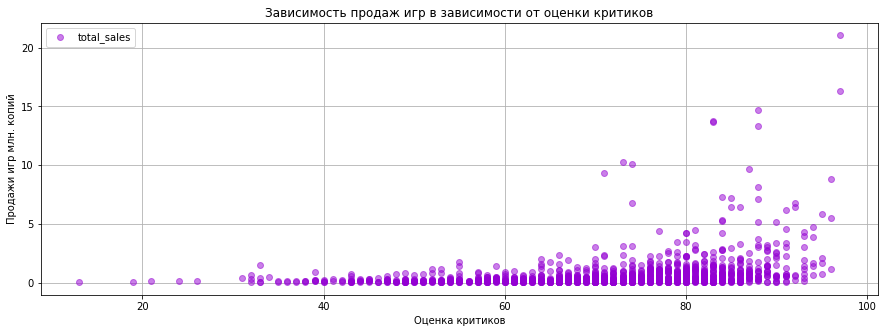

In [52]:
# зависимость от оценок критиков
(actually_games.query('platform not in ["PS4", "XOne", "3DS"]')
 .sort_values(by='critic_score', ascending=True)
 .plot(x='critic_score', y='total_sales', style='o', figsize=(15, 5), color='darkviolet',
       grid=True, alpha=0.5, title='Зависимость продаж игр в зависимости от оценки критиков')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка критиков')
plt.show()

In [53]:
# корреляция продаж от оценок критиков
actually_games.query('platform not in ["PS4", "XOne", "3DS"]')['critic_score'].corr(actually_games.query('platform not in ["PS4", "XOne", "3DS"]')['total_sales'])

0.3084260388656758

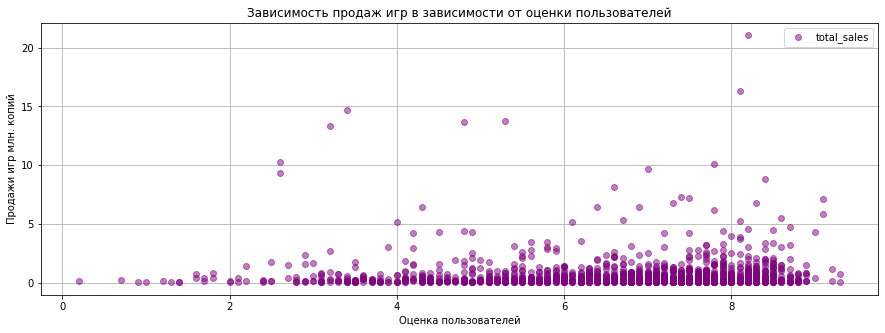

In [54]:
# зависимость от оценок пользователей
(actually_games.query('platform not in ["PS4", "XOne", "3DS"]')
 .sort_values(by='user_score', ascending=True)
 .plot(x='user_score', y='total_sales', style='o', figsize=(15, 5), color='purple',
       grid=True, alpha=0.5, title='Зависимость продаж игр в зависимости от оценки пользователей')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Оценка пользователей')
plt.show()

In [55]:
# корреляция продаж от оценок пользователей
actually_games.query('platform not in ["PS4", "XOne", "3DS"]')['user_score'].corr(actually_games.query('platform not in ["PS4", "XOne", "3DS"]')['total_sales'])

0.02546505418148919

#### Вывод 2


<div style="border:solid black 1px; padding: 10px">
По остальным платформам можно сделать следующие выводы:
- Имеется небольшая зависимость объема продаж от оценки критиков, особое увеличение продаж наблюдается при оценке от 75 и выше.
- Оценка пользователей на объемы продаж не влияет.

#### Распределение игр по жанрам

Посмотрю как рапределяются игры, какой жанр преобладает на рынке. Соберу данные при помощи сводной таблицы.

In [56]:
actually_games.pivot_table(index=['genre'], values='total_sales', aggfunc=['count', 'sum'])

,count,sum
,total_sales,total_sales
genre,,
Action,1269,557.80
Adventure,410,45.04
Fighting,159,66.90
Misc,375,139.42
Platform,122,88.68
Puzzle,71,9.85
Racing,180,88.31
Role-Playing,465,245.63


С огромным отрывом на рынке преобладают игры в жанре Action. Но при этом Shooter'ы, которые по объему выпущенных игр занимают лишь 9 место, занимают второе место по объему продаж.

Для визуализации построю диаграммы типа 'Пирог'.

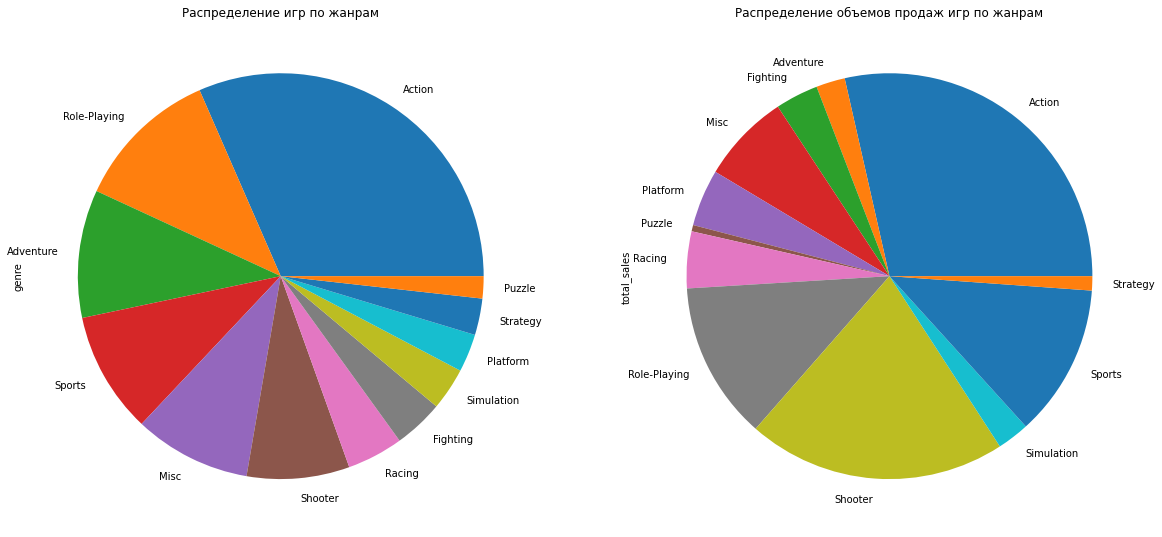

In [57]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 20))

actually_games['genre'].value_counts().plot(kind='pie', ax=axes[0], title='Распределение игр по жанрам');

(actually_games.groupby('genre')['total_sales'].sum().plot(kind='pie',
ax=axes[1], title='Распределение объемов продаж игр по жанрам'));

Общие наблюдения по распределнию жанров:
- Action занимает первую строчку как по объему выпускаемых игр, так и по объему продаж. Но это очевидно, чем больше игр, тем больше проданных копий.
- Shooter определенно можно назвать самым популярным жанром, при относительно небольшом объему игр, по объему продаж этот жанр занимает уверенное второе место.
- Третий по кол-во выпускаемых игр жанр Adventure занимает третье место с конца по побъему проданных копий.	
- Жанр Role-Playing	один из самых стабильных. Занимая третье место по объему выпускаемых игр, он также занимает третье место по объему проданных копий.

Результаты говорят о том, что совсем не обязательно, что популярный на рынке жанр игр, будет самым продаваем.
С точки зрения объема продаваемых копий, можно выделить следующие <b>самые популярные жанры игр<b/>:
- Shootrer
- Action
- Role-Playing
- Sports


## Составление портрета пользователя

### Самые популярные платформы (топ-5) в разных регионах

При помощи сводной таблицы, отображу объем продаж игр на игровые платформы в различных регионах:
- в Японии
- в Европе
- в Серевной Америке

In [58]:
region_platform = actually_games.pivot_table(index='platform', values = ['eu_sales', 'jp_sales', 'na_sales'], 
                                             aggfunc=['sum']).reset_index()

region_platform.columns = ['platform', 'eu_sales_sum', 'jp_sales_sum', 'na_sales_sum']
region_platform

,platform,eu_sales_sum,jp_sales_sum,na_sales_sum
0,3DS,61.27,100.62,82.65
1,DS,9.24,8.04,18.86
2,PC,56.70,0.00,29.88
3,PS2,0.13,0.09,0.13
4,PS3,163.10,49.39,168.26
5,PS4,141.09,15.96,108.74
6,PSP,1.77,24.04,2.19
7,PSV,13.07,21.84,12.47
8,Wii,29.60,8.97,48.56
9,WiiU,25.13,13.01,38.10


In [59]:
eu_top = region_platform.sort_values(by='eu_sales_sum', ascending=False)[:5]
eu_top = eu_top.drop(eu_top[['jp_sales_sum', 'na_sales_sum']], axis = 1)
display(eu_top)

jp_top = region_platform.sort_values(by='jp_sales_sum', ascending=False)[:5]
jp_top = jp_top.drop(jp_top[['eu_sales_sum', 'na_sales_sum']], axis = 1)
display(jp_top)

na_top = region_platform.sort_values(by='na_sales_sum', ascending=False)[:5]
na_top = na_top.drop(na_top[['eu_sales_sum', 'jp_sales_sum']], axis = 1)
na_top 


,platform,eu_sales_sum
4,PS3,163.10
5,PS4,141.09
10,X360,117.10
0,3DS,61.27
2,PC,56.70


,platform,jp_sales_sum
0,3DS,100.62
4,PS3,49.39
6,PSP,24.04
7,PSV,21.84
5,PS4,15.96


,platform,na_sales_sum
10,X360,226.80
4,PS3,168.26
5,PS4,108.74
11,XOne,93.12
0,3DS,82.65


In [60]:
# добавлю столбец с долями каждой топовой платформы на Европейском рынке
eu_top['fraction'] = eu_top['eu_sales_sum'] / eu_top['eu_sales_sum'].sum()
eu_top['fraction'] = eu_top['fraction'].round(2) 
eu_top

,platform,eu_sales_sum,fraction
4,PS3,163.10,0.30
5,PS4,141.09,0.26
10,X360,117.10,0.22
0,3DS,61.27,0.11
2,PC,56.70,0.11


In [61]:
# добавлю столбец с долями каждой топовой платформы на Японском рынке
jp_top['fraction'] = jp_top['jp_sales_sum'] / jp_top['jp_sales_sum'].sum()
jp_top['fraction'] = jp_top['fraction'].round(3) 
jp_top

,platform,jp_sales_sum,fraction
0,3DS,100.62,0.475
4,PS3,49.39,0.233
6,PSP,24.04,0.113
7,PSV,21.84,0.103
5,PS4,15.96,0.075


In [62]:
# добавлю столбец с долями каждой топовой платформы на Северо-Американском рынке
na_top['fraction'] = na_top['na_sales_sum'] / na_top['na_sales_sum'].sum()
na_top['fraction'] = na_top['fraction'].round(2) 
na_top

,platform,na_sales_sum,fraction
10,X360,226.80,0.33
4,PS3,168.26,0.25
5,PS4,108.74,0.16
11,XOne,93.12,0.14
0,3DS,82.65,0.12


С точки зрения продаж в исследуемых регионах можно определить следующие тор-5:

<b/>Япония:</b>
    
1. 3DS - похоже, эта приставка в топе в основном из-за продаж в Японии.
2. PS3 - удивительно, но в Японии почти в 3 раза менее популярна эта приставка, чем в Европе и Северной Америке
3. PSP
4. PSV
5. Wii U

Вывод по Японии - очевидно, что на Японскоп рынке лидируют портативные консоли.
В Японии не продаются для PS, возможно это связано с тем, что прогрес в стране восходящего солнца всегда впереди планеты всей, поэтому данная приствка там давно морально устарела.

<b>Европа:</b>
    
1. PS3
2. PS4
3. X360
4. 3DS
5. PC

Вывод по Европе - Европейский пользователь предпочитает игровые консоли и предпочтение отдает консолям производства компании Sony.

<b>Северная Америка:</b>
    
1. X360
2. PS3
3. PS4
4. XOne
5. 3DS

Вывод по Северной Америке - Пользователи с этого региона предпочитают X-Box, при чем продажи игр для этих консолей в Северной Америки почти в 2 раза больше, чем в Европе. В целом, заметно, что на рынке Северной Америки продает больше игр, чем в Европе и Японии.

На основании этого можно заключить, что _при составлении рекламной кампании, необходимо учитывать регион, на который запланированно ее направить._

Подкреплю этот вывод графически.

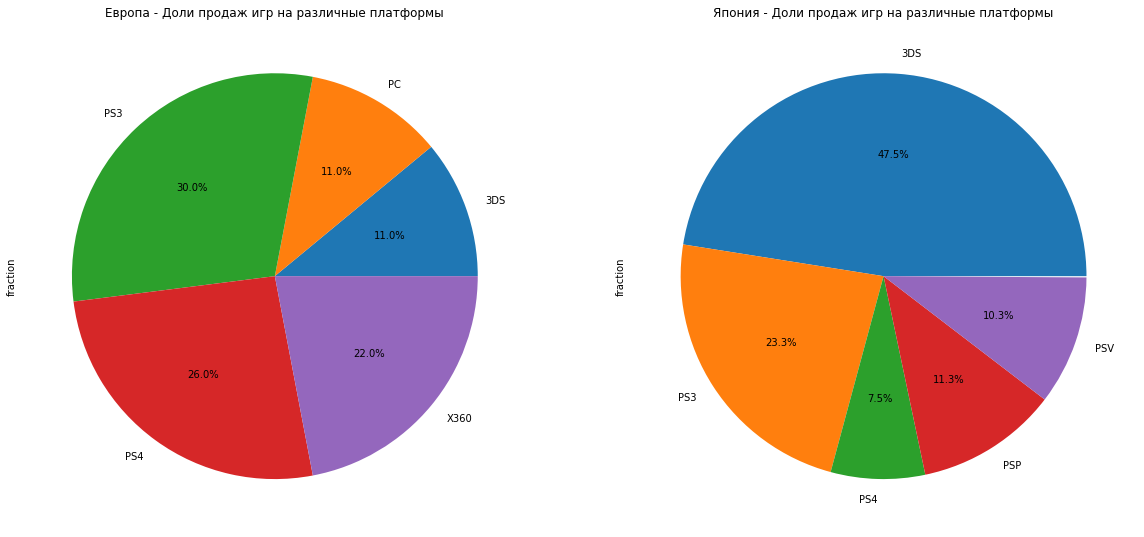

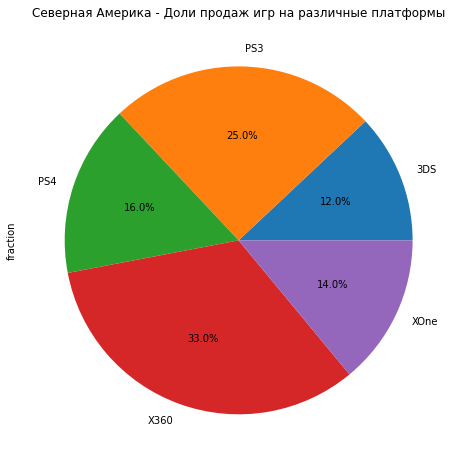

In [63]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 20))

(eu_top.groupby('platform')['fraction'].sum().plot(kind='pie',
ax=axes[0], title='Европа - Доли продаж игр на различные платформы', autopct='%1.1f%%'));


(jp_top.groupby('platform')['fraction'].sum().plot(kind='pie',
ax=axes[1], title='Япония - Доли продаж игр на различные платформы', autopct='%1.1f%%'));
plt.show()

(na_top.groupby('platform')['fraction'].sum().plot(kind='pie', figsize=(8, 8),
title='Северная Америка - Доли продаж игр на различные платформы', autopct='%1.1f%%'));
plt.show()

Графики очень хорошо визуализируют выводы. Видно, что в Японии почти 50% продаж игр приходится на 3DS.
Игры X-box разных поколений в Севверной Америке также занимают почти половину всего рынка.
Ну а в Еввропе уверено лидируют PS3 и PS4. 

### Самые популярные жанры (топ-5) в разных регионах

При помощи сводной таблицы, отображу объем продаж игр разных жанров в различных регионах:

- в Японии
- в Европе
- в Серевной Америке

In [64]:
region_genre = actually_games.pivot_table(index='genre', values = ['eu_sales', 'jp_sales', 'na_sales'], 
                                             aggfunc=['sum']).reset_index()

region_genre.columns = ['genre', 'eu_sales_sum', 'jp_sales_sum', 'na_sales_sum']
region_genre

,genre,eu_sales_sum,jp_sales_sum,na_sales_sum
0,Action,199.12,63.62,230.92
1,Adventure,13.96,12.07,14.76
2,Fighting,16.24,12.38,31.63
3,Misc,39.72,17.60,69.69
4,Platform,30.07,12.13,38.28
5,Puzzle,3.56,2.91,2.74
6,Racing,40.58,5.64,31.98
7,Role-Playing,62.30,79.87,83.78
8,Shooter,148.02,11.92,194.43
9,Simulation,19.72,11.64,15.37


Данные уже сведены, но пока они не наглядны. Как это было сделано ранее, я сделаю отдельные таблички по каждому региону. По ним мне будет проще построить графики для ввизуализации результатов.

In [65]:
# также как и на этапе ранее создаю таблицы со столбцом доли продаж
eu_top_genre = region_genre.sort_values(by='eu_sales_sum', ascending=False)[:5]
eu_top_genre = eu_top_genre.drop(eu_top_genre[['jp_sales_sum', 'na_sales_sum']], axis = 1).reset_index()
eu_top_genre['fraction'] = eu_top_genre['eu_sales_sum'] / eu_top_genre['eu_sales_sum'].sum() # добавляю доли каждого жанра
eu_top_genre['fraction'] = eu_top_genre['fraction'].round(2) 
display(eu_top_genre)

jp_top_genre = region_genre.sort_values(by='jp_sales_sum', ascending=False)[:5]
jp_top_genre = jp_top_genre.drop(jp_top_genre[['eu_sales_sum', 'na_sales_sum']], axis = 1).reset_index()
jp_top_genre['fraction'] = jp_top_genre['jp_sales_sum'] / jp_top_genre['jp_sales_sum'].sum() # добавляю доли каждого жанра
jp_top_genre['fraction'] = jp_top_genre['fraction'].round(2) 
display(jp_top_genre)

na_top_genre = region_genre.sort_values(by='na_sales_sum', ascending=False)[:5]
na_top_genre = na_top_genre.drop(na_top_genre[['eu_sales_sum', 'jp_sales_sum']], axis = 1).reset_index()
na_top_genre['fraction'] = na_top_genre['na_sales_sum'] / na_top_genre['na_sales_sum'].sum() # добавляю доли каждого жанра
na_top_genre['fraction'] = na_top_genre['fraction'].round(2) 
na_top_genre 

,index,genre,eu_sales_sum,fraction
0,0,Action,199.12,0.37
1,8,Shooter,148.02,0.27
2,10,Sports,88.48,0.16
3,7,Role-Playing,62.30,0.12
4,6,Racing,40.58,0.08


,index,genre,jp_sales_sum,fraction
0,7,Role-Playing,79.87,0.43
1,0,Action,63.62,0.34
2,3,Misc,17.60,0.09
3,2,Fighting,12.38,0.07
4,4,Platform,12.13,0.07


,index,genre,na_sales_sum,fraction
0,0,Action,230.92,0.34
1,8,Shooter,194.43,0.28
2,10,Sports,108.70,0.16
3,7,Role-Playing,83.78,0.12
4,3,Misc,69.69,0.10


На основании собранных данных сформирую следующие выводы относительно топ-5 жанров игр в разных регионах:

<b>Европа:</b>
    
1. Action - 37% 
2. Shooter - 27%	
3. Sports - 16%
4. Role-Playing - 12%
5. Racing - 8%	

Action является самым популярным жаром видео игр в Европе.


<b/>Япония:</b>
    
1. Role-Playing - 43%
2. Action - 34%
3. Misc - 9%
4. Fighting - 7%
5. Platform - 7%

Самым популярным жанром видео-игр в Японии является Role-Playing.

<b>Северная Америка:</b>
    
1. Action - 34%
2. Shooter - 28%
3. Sports - 16%
4. Role-Playing - 12%
5. Misc - 12%

Самым популярным жанром в Северной Америке является Action.

В целом по всем прослеживается, что:
- во всех регионах игры жанра Action имеют очень высокий уровень популярности
- в Японии не стоит выстраивать рекламную кампанию вокруг Shooter, в этом регионы они не популярны
- и в Европе и в Севверной Америке одинаково популярны игры жанров Sports и Role-Playing.



Подкреплю этот вывод графически.


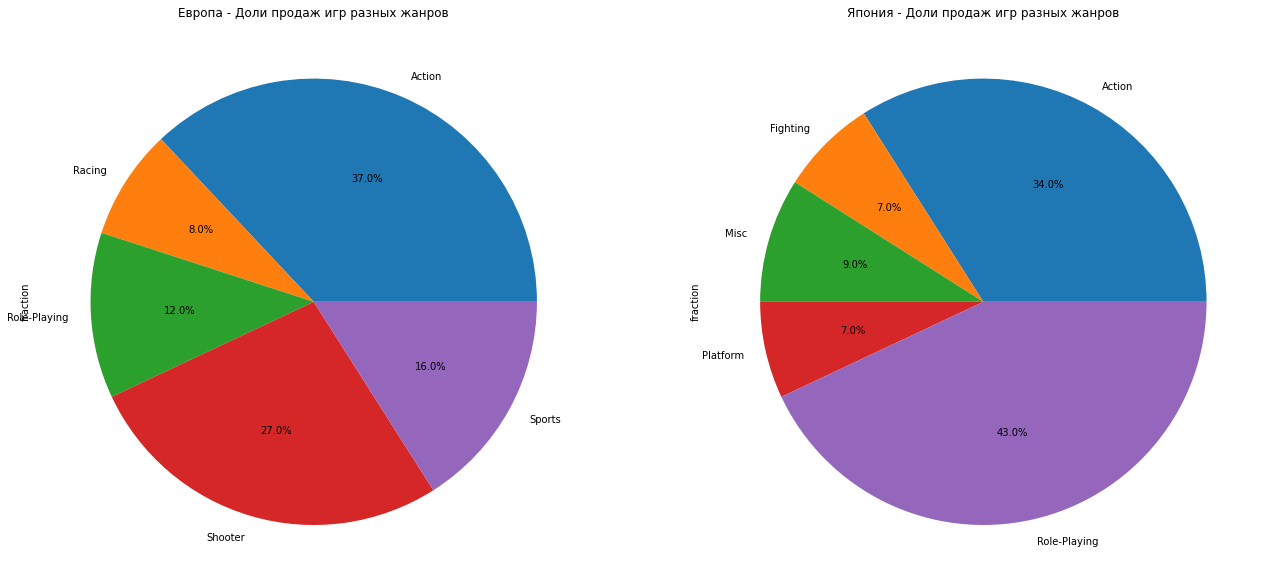

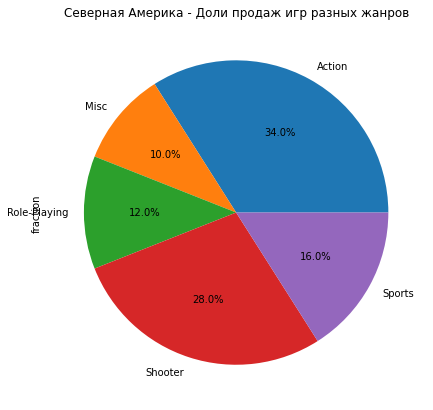

In [66]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(22, 22))

(eu_top_genre.groupby('genre')['fraction'].sum().plot(kind='pie',
ax=axes[0], title='Европа - Доли продаж игр разных жанров', autopct='%1.1f%%'));


(jp_top_genre.groupby('genre')['fraction'].sum().plot(kind='pie',
ax=axes[1], title='Япония - Доли продаж игр разных жанров', autopct='%1.1f%%'));
plt.show()

(na_top_genre.groupby('genre')['fraction'].sum().plot(kind='pie', figsize=(7, 7),
title='Северная Америка - Доли продаж игр разных жанров', autopct='%1.1f%%'));
plt.show()


На графиках выводы отображены более наглядно.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Составлю сводную таблицу в зависимости от рейтинга ESRB игры.

Обозначу, что означает тот или иной рейтинг:
- E - Для всех (от 6 лет)
- E10+ - Для детей старше 10 лет
- EC - Для детей младшего возраста (от 3 лет)
- M	- От 17 лет
- RP - Рейтин не присвоен (ожидается)	
- T - Подросткам 13-19 лет

In [67]:
region_rating = actually_games.pivot_table(index='rating', values = ['eu_sales', 'jp_sales', 'na_sales'], 
                                             aggfunc=['sum']).reset_index()

region_rating.columns = ['rating', 'eu_sales_sum', 'jp_sales_sum', 'na_sales_sum']
region_rating

,rating,eu_sales_sum,jp_sales_sum,na_sales_sum
0,E,141.73,36.68,170.17
1,E10+,78.00,11.23,117.72
2,EC,0.00,0.00,0.42
3,M,250.26,26.14,308.45
4,RP,0.03,0.00,0.00
5,T,83.16,33.39,109.31
6,no_info,116.61,138.21,123.69


In [68]:
# составлю таблицы, для построения гистограмм
eu = region_rating[['rating', 'eu_sales_sum']]
jp = region_rating[['rating', 'jp_sales_sum']]
na = region_rating[['rating', 'na_sales_sum']]

display(eu)
display(jp)
na

,rating,eu_sales_sum
0,E,141.73
1,E10+,78.00
2,EC,0.00
3,M,250.26
4,RP,0.03
5,T,83.16
6,no_info,116.61


,rating,jp_sales_sum
0,E,36.68
1,E10+,11.23
2,EC,0.00
3,M,26.14
4,RP,0.00
5,T,33.39
6,no_info,138.21


,rating,na_sales_sum
0,E,170.17
1,E10+,117.72
2,EC,0.42
3,M,308.45
4,RP,0.00
5,T,109.31
6,no_info,123.69


Красивые таблички, мне нравится:) Иду дальше. Построю гистограммы.

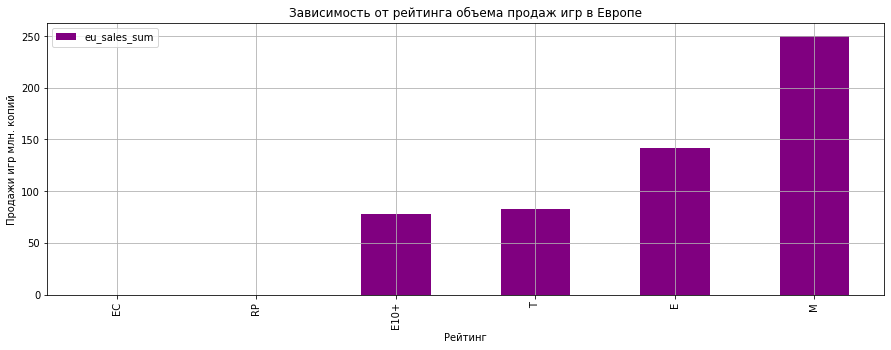

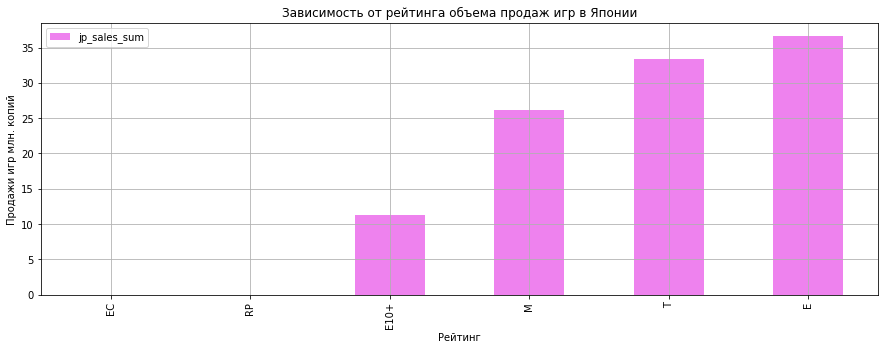

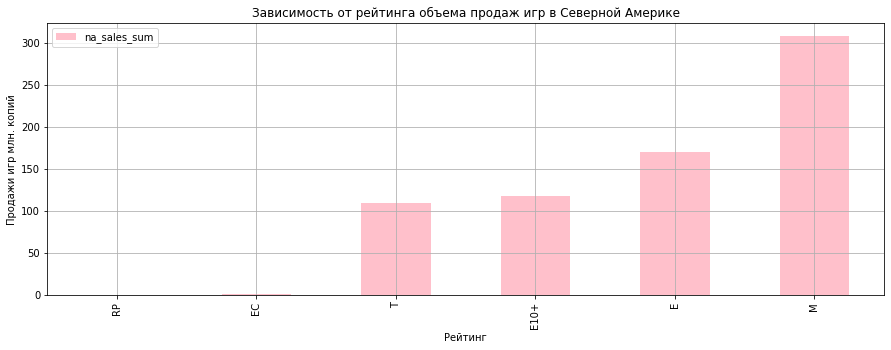

In [69]:
# по каждому графику исключу строки без рейтинга, там где указано no_info
# Европа
(eu.query('rating != "no_info"').sort_values(by='eu_sales_sum', ascending=True)
 .plot(x='rating', y='eu_sales_sum', kind='bar', figsize=(15, 5), color='purple',
       grid=True, title='Зависимость от рейтинга объема продаж игр в Европе')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Рейтинг')
plt.show()

# Япония
(jp.query('rating != "no_info"').sort_values(by='jp_sales_sum', ascending=True)
 .plot(x='rating', y='jp_sales_sum', kind='bar', figsize=(15, 5), color='violet',
       grid=True, title='Зависимость от рейтинга объема продаж игр в Японии')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Рейтинг')
plt.show()

# Северная Америка
(na.query('rating != "no_info"').sort_values(by='na_sales_sum', ascending=True)
 .plot(x='rating', y='na_sales_sum', kind='bar', figsize=(15, 5), color='pink',
       grid=True, title='Зависимость от рейтинга объема продаж игр в Северной Америке')
)

plt.ylabel('Продажи игр млн. копий')
plt.xlabel('Рейтинг')
plt.show()

По построенным данным можно сделать следующие выводы:

- Игры с рейтингом М (от 17 лет) имеет самые высокие продажи в Европе и Америке
- В Японии игры с рейтингом Е (для всех) и Т (подросткам от 13 до 19 лет)
- во всех регионах нет продаж игр с рейтингом ЕС (для детей от 3 лет) и неопределнным рейтингом RP

### Вывод по этапу

<div style="border:solid black 1px; padding: 10px">

Среднестатистический пользователь из Европы предпочитает:
- предпочитает играть на консолях PS3 и PS4
- играет в игры жанров Action и Shooter 
- играет в игры с рейтингом М (от 17 лет)

Среднестатистический пользователь из Японии предпочитает:
- предпочитает играть на портативной консоли 3DS
- играет в игры жанров Role-Playing и Action
- играет в игры с рейтингом Е (для всех) и Т (подросткам от 13 до 19 лет)

Среднестатистический пользователь из Северной Америки предпочитает:
- предпочитает играть на консолях произвводителя Microsoft типа X-box
- играет в игры жанров Action и Shooter 
- играет в игры с рейтингом М (от 17 лет)


## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Выстраивать гипотезы я буду отталкиваясь от равенства:

Н₀(нулевая гипотеза) - Средние пользовательские рейтинги платформ Xbox One и PC _одинаковые_

Н₁(альтернативная гипотеза) - Средние пользовательские рейтинги платформ Xbox One и PC _различные_. Данная гипотеза двустороняя, так как различие может быть как вв большую, так и в меньшую сторону.

Критический уровень alpha возьму за 5% (0.05).

В первую очередь хочу проверить на сколько различаются выборки.

In [70]:
actually_games['user_score'].min()

0.2

In [71]:
# в том числе, исключаю строки без оценок, чтобы не получить ошибку расчетов

xone_score = actually_games.query('platform == "XOne" & user_score >= 0.2') 
pc_score = actually_games.query('platform == "PC" & user_score >= 0.2')

xone_var = np.var(xone_score['user_score'], ddof=1)
pc_var = np.var(pc_score['user_score'], ddof=1)


print(f'Данных об оценках на Xbox One {len(xone_score)}')
print(f'Данных об оценках на PC {len(pc_score)}')
print(f'Дисперсия данных об оценках Xbox One {xone_var}')
print(f'Дисперсия данных об оценках PC {pc_var}')

Данных об оценках на Xbox One 182
Данных об оценках на PC 307
Дисперсия данных об оценках Xbox One 1.9069968429360695
Дисперсия данных об оценках PC 2.5962957995358837


Размеры выборок различаются, дисперсии не равны. Я буду использовать Т-тест с указанием equal_var=False

In [72]:
xone = xone_score['user_score'] # данные об оценках пользователей X-Box One
pc = pc_score['user_score'] # данные об оценках пользователей PC

alpha = .05 # критические уровень значимости

results = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.6130712247638477
Не получилось отвергнуть нулевую гипотезу


#### Вывод
P-pvalue говорит о том, что имеется вероятность в 61%, что средние пользовательские рейтинги у Xbox One и PC могут совпадать. Отвергнуть нулевую гипотезу нельзя.

### Средние пользовательские рейтинги жанров Action и Sports разные

Выстраивать гипотезы я также буду отталкиваясь от равенства:

Н₀(нулевая гипотеза) - Средние пользовательские рейтинги жанров Action и Sports _одинаковые_

Н₁(альтернативная гипотеза) - Средние пользовательские рейтинги жанров Action и Sports _различные_, Action больше.

Критический уровень alpha возьму за 5% (0.05).

В первую очередь хочу проверить на сколько различаются выборки.

In [73]:
action_score = actually_games[(actually_games['genre'] == 'Action') & 
                              (~actually_games['user_score'].isna())]['user_score']

sports_score = actually_games[(actually_games['genre'] == 'Sports') & 
                              (~actually_games['user_score'].isna())]['user_score']

action_var = np.var(action_score, ddof=1)
sports_var = np.var(sports_score, ddof=1)


print(f'Данных об оценках игр в жанре Action {len(action_score)}')
print(f'Данных об оценках игр в жанре Sports {len(sports_score)}')
print(f'Дисперсия данных об оценках игр в жанре Action {action_var}')
print(f'Дисперсия данных об оценках игр в жанре Sports {sports_var}')

Данных об оценках игр в жанре Action 664
Данных об оценках игр в жанре Sports 246
Дисперсия данных об оценках игр в жанре Action 1.8118770103036579
Дисперсия данных об оценках игр в жанре Sports 2.8825095404015264


Размер выборок различается почти в 3 раза. Проверим через t-test методом st.ttest_1samp срванивая оценки в Sports со средней оценкой в Action.

In [74]:
mean_action = action_score.mean() #средняя оценка жанра Action

alpha = .05 # критические уровень значимости

results_2 = st.ttest_1samp(sports_score, mean_action)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results_2.pvalue / 2)

# тест односторонний вправо:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
if ((results_2.pvalue / 2) < alpha) and (sports_score.mean() <= mean_action):
    print("Отвергаем нулевую гипотезу, средние пользовательские оценки в жанре Action выше")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.6796918304611546e-21
Отвергаем нулевую гипотезу, средние пользовательские оценки в жанре Action выше


П-значение ничтожно мало. Не удалось найти подтверждения гипотезы о том, что средние пользовательские оценки в жанрах Action и Sports равны. Удалось найти подтвверждение гипотезы, что средние оценки Action выше.

## Общие выводы

<div style="border:solid black 1px; padding: 10px">
    
<b>Актуальный период для исследования:</b>
- опираясь на жизненный цикл консолей, для исследования нужно брать период не более 6 лет.

<b>Перечень потенциально перспективных игровых приставок в мире:</b>
- PS4
- XOne
- 3DS
- PS3
- X360

<b>Влияния на объем продаж:</b>
- оценки критиков влияют на объем продаж
- оценки пользователей не влияют на объем продаж

<b>Самые популярные жанры игр в Мире:</b>
- Shootrer
- Action
- Role-Playing
- Sports

<b>Популярность платформ в Европе, Японии и Северной Америке:</b>
- в этих регионах перечень популярных платформ отличается. Это нужно иметь виду при планировании рекламной кампании.

<b>Описание среднестатистического пользователя:</b>
    
_Среднестатистический пользователь из Европы предпочитает:_
- предпочитает играть на консолях PS3 и PS4
- играет в игры жанров Action и Shooter 
- играет в игры с рейтингом М (от 17 лет)

_Среднестатистический пользователь из Японии предпочитает:_
- предпочитает играть на портативной консоли 3DS
- играет в игры жанров Role-Playing и Action
- играет в игры с рейтингом Е (для всех) и Т (подросткам от 13 до 19 лет)

_Среднестатистический пользователь из Северной Америки предпочитает:_
- предпочитает играть на консолях произвводителя Microsoft типа X-box
- играет в игры жанров Action и Shooter 
- играет в игры с рейтингом М (от 17 лет)

<b>Проверка гипотез:</b>
- Не удалось отвергнуть гипотезу, о равенстве средних пользовательских оценок для Xbox One и PC. Существует высокая доля вероятности, что средние оценки будут равны.
- Гипотеза о равенстве средних пользовательских оценках игр в жанрах Action и Sports опроввергнута. Средние пользовательские оценки жанра Action выше.    
    
<b>Рекомендации для "Стримчик" на 2017 год:</b>    
- сделать в своей рекламной кампании упор, на игры в жанрах  Action и Shooter. 
- в рекламной кампании делать упор на консоли типа PS4 и Xbox One, именно они будут в ближайшей перспективе на плаву.    
- если рекламная кампания направлена на азиатский рынок, то упор формировать на портативные консоли и игры игры в жанрах Role-Playing и Action. 
    
